# Optional exploration of discretization methods used in the candidate_label_creation notebook
In this notebook, we will explore how to discretize numeric-valued attribute labels.

*What do we mean by "discretize numeric-valued attribute labels"?*  
--> Example: If we look at the labels we have for "beers that have an ABV of *X*", we will get many labels that have different values that might be close together. By discretizing them, we will create bins of ABV values so that we can have labels that capture "beers that have an ABV between *Y* and *Z*". This should give us labels that are applicable to more entities and are hopefully more meaningful for profiling.

*What methods will we explore?*  
--> The paper that this entity profiling procedure is based on mentions using a fixed-width bin size for certain numeric types like years, and a density-based discretization method otherwise. We will look at using fixed-width bins, but we will primarily look at DBSCAN (Density-based spatial clustering of applications with noise). We will also see how we can automate selecting parameters for DBSCAN. Another tool that may be better suited for our task that we plan to explore in the future is KDE (Kernel Density Estimation).

*What method is used in the candidate label creation notebook?*  
--> DBSCAN + automated parameter selection to create clusters, then infer bin-ranges from the clusters.

*Resources:*  
- Article explaining how to tune DBSCAN's parameters: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
- Stack overflow post with an answer explaining how KDE would be a better-suited tool for our clustering: https://stackoverflow.com/questions/11513484/1d-number-array-clustering

### Pre-requisite steps to run this notebook
1. You need to run the candidate_label_creation notebook before this notebook. Once you have completed step 2 of that notebook (AVL creation), then you can run this one.
2. kneed (https://pypi.org/project/kneed/) is a dependency. Install this either through Anaconda with `conda install -c conda-forge kneed`, or through pip with `pip install kneed`

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from utility import rename_cols_and_overwrite_id

### Parameters
**Required**  
*item_file*: file path for the file that contains entity to entity relationships (e.g. wikibase-item)  
*time_file*: file path for the file that contains entity to time-type values  
*quantity_file*: file path for the file that contains entity to quantity-type values (remember to specify the trimmed file if you did the quantity file trimming pre-processing step).  
*label_file*: file path for the file that contains wikidata labels  
*work_dir*: path to work_dir that was specified in the candidate_label_creation notebook. We will look for files in this folder that were created by the candidate_label_creation notebook.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [15]:
data_dir = "../../wikidata_films/data" # my data files are all in the same directory, so I'll reuse this path prefix

item_file = "{}/claims.wikibase-item.tsv.gz".format(data_dir)
time_file = "{}/claims.time.tsv.gz".format(data_dir)
quantity_file = "{}/claims.quantity_trimmed.tsv.gz".format(data_dir)
label_file = "{}/labels.en.tsv.gz".format(data_dir)
work_dir = "../../wikidata_films/profiler_work"
store_dir = "../../wikidata_films"

### Process parameters and set up variables / file names

In [16]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
time_file = os.path.abspath(time_file)
quantity_file = os.path.abspath(quantity_file)
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)

# Create subdirectory where files created by this notebook can go 
out_dir = "{}/explore_label_disc".format(work_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# adding some environment variables we'll be using frequently
os.environ['ITEM_FILE'] = item_file
os.environ['TIME_FILE'] = time_file
os.environ['QUANTITY_FILE'] = quantity_file
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['OUT'] = out_dir
os.environ['kgtk'] = "kgtk"

### Helpers for using DBSCAN to create clusters and viewing them

In [32]:
# Uses DBSCAN to assign labels of a particular type and property to clusters
def DBSCAN_label_subset(filename, eps, min_samples, l_type, l_prop, l_si = None, l_wd = None):
    df = pd.read_csv(filename, delimiter='\t')
    
    # dbscan expects multiple dimensions
    df["zeros"]=0
    
    # filter by type and property, and units if given
    df = df.loc[df["node1"] == l_type]
    df = df.loc[df["label"] == l_prop]
    if l_si is not None:
        df = df.loc[df["si_units"] == l_si]
    if l_wd is not None:
        df = df.loc[df["wd_units"] == l_wd]
        
    values_w_0s = df.loc[:, ["node2", "zeros"]]
    values = values_w_0s.loc[:,"node2"]
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(values_w_0s)

    return (db, values)


# Chooses values for the epsilon and min_samples parameters of DBSCAN to be used for
# clustering labels of a given type and property.
def choose_DBSCAN_params(filename, l_type, l_prop, l_si = None, l_wd = None):
    df = pd.read_csv(filename, delimiter='\t')
    
    # filter by type and property, and units if given
    df = df.loc[df["node1"] == l_type]
    df = df.loc[df["label"] == l_prop]
    if l_si is not None:
        df = df.loc[df["si_units"] == l_si]
    if l_wd is not None:
        df = df.loc[df["wd_units"] == l_wd]
        
    values = np.array(df.loc[:,"node2"]).reshape(-1, 1)
    
    # min_samples would ideally be set with some domain-insight.
    # To make this automated, we'll use a heuristic - ln(number of data points)
    min_samples = int(np.floor(np.log(len(values))))
    min_samples = max(min_samples, 1) # don't choose a number less than 1
    print("Choosing min_samples = floor(ln(# data points)) = {}".format(min_samples))
    
    # epsilon can be chosen by plotting the distances of the k'th nearest neighbor from each point
    # where k is min_samples. Points that belong to clusters should have smaller distances, whereas
    # noise points can have distances that are much farther. We'll look for a knee in this graph to set epsilon.
    print("Computing distances to k'th nearest neighbor for each point where k = min_samples...")
    
    neigh = NearestNeighbors(n_neighbors = min_samples + 1) # +1 so we find k'th nearest neighbor not including the point iteslf.
    values_neigh = neigh.fit(values)
    distances, indices = values_neigh.kneighbors(values)
    distances = np.sort(distances[:,min_samples], axis = 0)
    
    kneedle = KneeLocator(range(len(distances)), distances, S=1, curve='convex', direction='increasing', interp_method = 'polynomial')
    kneedle.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    print("knee found at distance {}".format(kneedle.knee_y))
    epsilon = kneedle.knee_y
    
    return (min_samples, epsilon)


# Given values that have been assigned to clusters,
# return a list of intervals that are consistent with these clusters
def infer_intervals_from_clusters(values, labels):
    
    values = np.array(values)
    labels = np.array(labels)
    
    # sort values and corresponding labels in ascending order
    labels = np.array([l for l, v in sorted(zip(labels, values), key=lambda pair: pair[1])])
    values.sort()
    
    intervals = [(None, None)] # initially a single interval with no lower or upper bound
    
    cur_label = labels[0]
    for i in range(len(labels)):
        # if new label, set upper bound of previous interval,
        # and start lower bound of a new interval.
        if labels[i] != cur_label:
            prev_interval_lb = (intervals[-1])[0]
            new_interval_edge = values[i-1] + ((values[i] - values[i-1]) / 2)
            intervals[-1] = (prev_interval_lb, new_interval_edge)
            intervals.append((new_interval_edge, None))
            cur_label = labels[i]
    
    return intervals
    

def fixed_width_partition(filename, width, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
   # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values = df.loc[:,"node2"]
    labels = values - (values % width)
    
    return (labels, values)
    

def view_clustering(labels, values, min_hist_bin = None, max_hist_bin = None, bin_size = None):
    if min_hist_bin is None:
        min_hist_bin = values.min() - 1
    if max_hist_bin is None:
        max_hist_bin = values.max() + 1
    if bin_size is None:
        bin_size = (max_hist_bin - min_hist_bin) / 10 # default 10 bins

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Number of data points: {}'.format(len(labels)))
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)


    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(.05, .9, len(unique_labels))]
    
    ax = plt.gca()
    ax.set_facecolor("xkcd:silver")

    for k, col in zip(unique_labels, colors):
        #col = [0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0]
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = values.loc[class_member_mask]
        plt.hist(xy, color=tuple(col), bins = np.arange(min_hist_bin, max_hist_bin, bin_size), histtype = 'stepfilled')

    plt.xlabel("value")
    plt.ylabel("count")
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

## Gather triples to discretize...
### Start by creating a type mapping
We will create intervals for properties of an entity that are specific to the entity's type.

Mapping is from entity (Q node) to the entity's type (another Q node). Using P31 only for now, but can add P279* as well later.

In [5]:
!kgtk query -i $ITEM_FILE -i $LABEL_FILE \
-o $OUT/type_mapping.tsv --graph-cache $STORE \
--match '`'"$ITEM_FILE"'`: (e)-[l {label:"P31"}]->(type), `'"$LABEL_FILE"'`: (e)-[:label]->(e_lab), `'"$LABEL_FILE"'`: (type)-[:label]->(type_lab)' \
--return 'distinct l as id, e as node1, l.label as label, type as node2, e_lab as entity_label, type_lab as type_label' \
--where 'e_lab.kgtk_lqstring_lang_suffix = "en" AND type_lab.kgtk_lqstring_lang_suffix = "en"'

In [18]:
display(pd.read_csv("{}/type_mapping.tsv".format(os.environ["OUT"]), delimiter = '\t', nrows=5).fillna(""))

,id,node1,label,node2,entity_label,type_label
0,P10-P31-Q18610173-85ef4d24-0,P10,P31,Q18610173,'video'@en,'Wikidata property to link to Commons'@en
1,P1000-P31-Q18608871-093affb5-0,P1000,P31,Q18608871,'record held'@en,'Wikidata property for items about people'@en
2,P1001-P31-Q15720608-deeedec9-0,P1001,P31,Q15720608,'applies to jurisdiction'@en,'Wikidata qualifier'@en
3,P1001-P31-Q22984026-8beb0cfe-0,P1001,P31,Q22984026,'applies to jurisdiction'@en,'Wikidata property related to law and justice'@en
4,P1001-P31-Q22997934-1e5b1a96-0,P1001,P31,Q22997934,'applies to jurisdiction'@en,'Wikidata property related to government and s...


### Gather table of <entity, type, property, value> for year attribute labels

In [7]:
!kgtk query -i $OUT/type_mapping.tsv -i $TIME_FILE -i $LABEL_FILE \
-o $OUT/entity_attribute_labels_time.year.tsv --graph-cache $STORE \
--match '`'"$TIME_FILE"'`: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), `'"$LABEL_FILE"'`: (p)-[:label]->(p_lab), `'"$LABEL_FILE"'`: (type)-[:label]->(t_lab)' \
--return 'distinct n1 as entity, type as type, p as prop, kgtk_date_year(n2) as value, t_lab as type_label, p_lab as property_label, "_" as id' \
--where 't_lab.kgtk_lqstring_lang_suffix = "en" AND p_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'n1'

In [8]:
rename_cols_and_overwrite_id("$OUT/entity_attribute_labels_time.year", ".tsv", "type prop value", "node1 label node2")

In [19]:
!head -5 $OUT/entity_attribute_labels_time.year.tsv | column -t -s $'\t'

entity  node1      label  node2  type_label                                            property_label          id
P2847   Q18608871  P2669  2019   'Wikidata property for items about people'@en         'discontinued date'@en  E1
P2847   Q24239898  P2669  2019   'Wikidata property for Wikivoyage listings'@en        'discontinued date'@en  E2
P2847   Q30041186  P2669  2019   'Wikidata property related to online communities'@en  'discontinued date'@en  E3
P2847   Q60457486  P2669  2019   'Wikidata property for a discontinued website'@en     'discontinued date'@en  E4


### Gather table of <entity, type, property, value, si_units, wd_units> for quantity attribute labels
We don't do any unit conversions, instead we consider si_units, wd_units as part of the property.

In [10]:
!kgtk query -i $OUT/type_mapping.tsv -i $QUANTITY_FILE -i $LABEL_FILE \
-o $OUT/entity_attribute_labels_quantity.tsv --graph-cache $STORE \
--match '`'"$QUANTITY_FILE"'`: (n1)-[l {label:p}]->(n2), type: (n1)-[]->(type), `'"$LABEL_FILE"'`: (p)-[:label]->(p_lab), `'"$LABEL_FILE"'`: (type)-[:label]->(t_lab)' \
--return 'distinct n1 as entity, type as type, p as prop, kgtk_quantity_numeral(n2) as value, kgtk_quantity_si_units(n2) as si_units, kgtk_quantity_wd_units(n2) as wd_units, t_lab as type_label, p_lab as property_label, "_" as id' \
--where 't_lab.kgtk_lqstring_lang_suffix = "en" AND p_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'n1'

In [11]:
rename_cols_and_overwrite_id("$OUT/entity_attribute_labels_quantity", ".tsv", "type prop value", "node1 label node2")

In [20]:
display(pd.read_csv("{}/entity_attribute_labels_quantity.tsv".format(os.environ["OUT"]), delimiter = '\t', nrows=5).fillna(""))


,entity,node1,label,node2,si_units,wd_units,type_label,property_label,id
0,P1004,Q19829908,P4876,37427,,,'Wikidata property for authority control for p...,'number of records'@en,E1
1,P1004,Q24075706,P4876,37427,,,"'Wikidata property for authority control, with...",'number of records'@en,E2
2,P1004,Q27525351,P4876,37427,,,'Wikidata property related to music'@en,'number of records'@en,E3
3,P1014,Q27918607,P4876,53249,,,'Wikidata property related to art'@en,'number of records'@en,E4
4,P1014,Q43831109,P4876,53249,,,'Wikidata property related to architecture'@en,'number of records'@en,E5


## Now we will explore how we can discretize these labels

In [21]:
# sorry this is hacky.
time_labels_file = "{}/entity_attribute_labels_time.year.tsv".format(out_dir)
quantity_labels_file = "{}/entity_attribute_labels_quantity.tsv".format(out_dir)

We'll start by looking at year values as an example

Taking a look at most prevalent type, property pairs within year-valued labels

In [23]:
!kgtk query -i $OUT/entity_attribute_labels_time.year.tsv \
--graph-cache $STORE \
--match 'time: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val)' \
--return 'distinct type as type, p as prop, count(e) as count, t_lab as type_label, p_lab as property_label' \
--order-by 'count(e) desc' \
--limit 5 \
| column -t -s $'\t'

type       prop   count   type_label              property_label
Q11424     P577   181080  'film'@en               'publication date'@en
Q5         P569   180642  'human'@en              'date of birth'@en
Q5         P570   63293   'human'@en              'date of death'@en
Q5         P2031  55772   'human'@en              'work period (start)'@en
Q20667187  P577   15284   'silent short film'@en  'publication date'@en


Let's look at year values for type = **film** prop = **publication date**

First let's see what triples match these labels...

In [30]:
!kgtk query -i $OUT/entity_attribute_labels_time.year.tsv -i $LABEL_FILE \
--graph-cache $STORE \
--match 'time: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val), `'"$LABEL_FILE"'`: (e)-[:label]->(e_lab)' \
--return 'distinct e as entity, type as type, p as prop, val as year, e_lab as entity_label, t_lab as type_label, p_lab as property_label' \
--where 'type = "Q11424" AND p = "P577" AND e_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'kgtk_quantity_number_int(val)' \
--limit 10 \
| column -t -s $'\t'

entity     type    prop  year  entity_label                                                 type_label  property_label
Q22694757  Q11424  P577  1895  'Discussion de Monsieur Janssen et de Monsieur Lagrange'@en  'film'@en   'publication date'@en
Q25477658  Q11424  P577  1895  'Attilla No. 2'@en                                           'film'@en   'publication date'@en
Q25477661  Q11424  P577  1895  'A Frontier Scene'@en                                        'film'@en   'publication date'@en
Q25477665  Q11424  P577  1895  'Billy Edwards and the Unknown'@en                           'film'@en   'publication date'@en
Q25477679  Q11424  P577  1895  'Charge of the Uhlans'@en                                    'film'@en   'publication date'@en
Q25477707  Q11424  P577  1895  'Cricketer Jumping Over Garden Gate'@en                      'film'@en   'publication date'@en
Q25477719  Q11424  P577  1895  'Cyclone Dance'@en                                           'film'@en   'publication date'@en

### Testing out DBSCAN with varying values for parameters epsilon and min_samples
epsilon: distance away from a point that we consider "in the neighborhood" of that point

min_samples: minimum number of points within a point's neighborhood (including the point itself) for us to consider these points as a core point

core points and points within their neighborhoods form clusters

**eps = 5, min_samples = 1**

Note that with min_samples = 1, all points will belong to a cluster since a single point can constitute its own cluster.

Number of data points: 181080
Estimated number of clusters: 2
Estimated number of noise points: 0


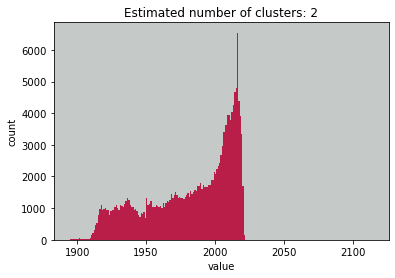

In [33]:
db, values = DBSCAN_label_subset(time_labels_file, l_type = "Q11424", l_prop = "P577", eps = 5, min_samples = 1)
view_clustering(db.labels_, values, bin_size = 1)

**eps = 3, min_samples = 10000**

Number of data points: 181080
Estimated number of clusters: 1
Estimated number of noise points: 70175


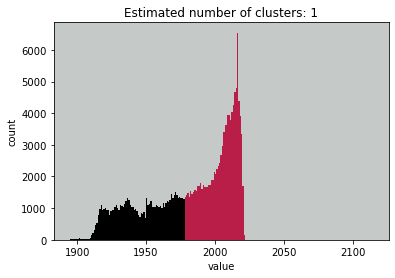

In [34]:
db, values = DBSCAN_label_subset(time_labels_file, l_type = "Q11424", l_prop = "P577", eps = 3, min_samples = 10000)
view_clustering(db.labels_, values, bin_size = 1)

**eps = 5, min_samples = 6000**

Number of data points: 181080
Estimated number of clusters: 1
Estimated number of noise points: 458


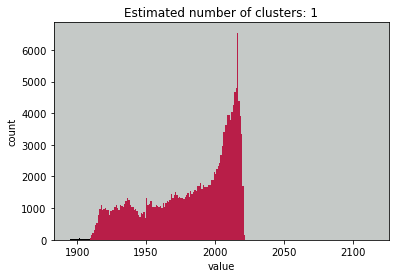

In [35]:
db, balues = DBSCAN_label_subset(time_labels_file, l_type = "Q11424", l_prop = "P577", eps = 5, min_samples = 6000)
view_clustering(db.labels_, values, bin_size = 1)

### If instead of DBSCAN we just use a fixed width of 5 years...

In [36]:
labels, values = fixed_width_partition(time_labels_file, width = 5, l_type = "Q11424", l_prop = "P577")

Number of data points: 181080
Estimated number of clusters: 27
Estimated number of noise points: 0


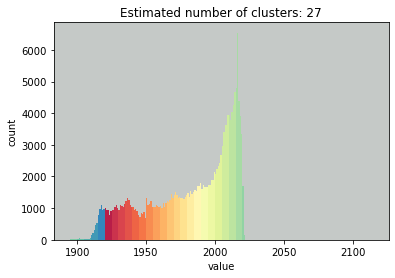

In [37]:
view_clustering(labels, values, bin_size = 1)

### Now using an automated approach to set DBSCAN parameters

min_samples is chosen using a heuristic that is a function of number of data points

epsilon will then be chosen based on the value for min_samples that was chosen. The distance you have to go from a given point to find min_samples number of points will be small and fairly similar for points that are in a more densley packed area, and larger for points in a more sparsely packed area. We want to set epsilon to some distance that will put the dense areas into clusters. To do this, we can plot the distances of the min_samples'th nearest neighbor from each point in increasing order of distance. If we look at where distance most sharply increases, this should correspond to the border between the distance for a point in a dense area and the distance for a point in a more sparse area. We'll choose this distance for epsilon.

Choosing min_samples = floor(ln(# data points)) = 12
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 0.0


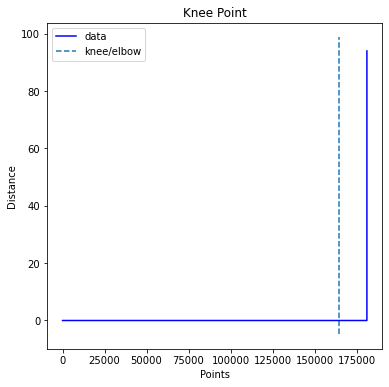

In [38]:
min_samples, epsilon = choose_DBSCAN_params(time_labels_file, l_type = "Q11424", l_prop = "P577")

In [39]:
db, values = DBSCAN_label_subset(time_labels_file, l_type = "Q11424", l_prop = "P577", eps = epsilon, min_samples = min_samples)
view_clustering(db.labels_, values, bin_size = 1)

ValueError: eps must be positive.

### We want explicit intervals, not just an assignment of the points we have to clusters.
We can find intervals that are compatible with the clustering we have. Here is the result for the above clustering:

In [70]:
intervals = infer_intervals_from_clusters(values, db.labels_)
display(intervals)

[(None, 1733.5), (1733.5, None)]

### Next let's look at what the clustering looks like for another type that has more data samples
We'll look at quantities now

Taking a look at most prevalent type, property pairs within quantity-valued labels

In [41]:
!kgtk query -i $OUT/entity_attribute_labels_quantity.tsv -o $OUT/quantity_label_counts_by_type_prop.tsv \
--graph-cache $STORE \
--match 'quantity: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab, si_units:si, wd_units:wd}]->(val)' \
--return 'distinct type as type, p as prop, si as si_units, wd as wd_units, count(e) as count, t_lab as type_label, p_lab as property_label' \
--order-by 'count(e) desc'

In [42]:
display(pd.read_csv("{}/quantity_label_counts_by_type_prop.tsv".format(out_dir), delimiter = '\t', nrows=5).fillna(""))

,type,prop,si_units,wd_units,count,type_label,property_label
0,Q11424,P2047,,Q7727,59448,'film'@en,'duration'@en
1,Q5,P2048,,Q174728,5105,'human'@en,'height'@en
2,Q5,P1971,,,4500,'human'@en,'number of children'@en
3,Q24862,P2047,,Q7727,3749,'short film'@en,'duration'@en
4,Q5,P2067,,Q11570,3121,'human'@en,'mass'@en


Let's look at values for type = **film** prop = **duration**

Choosing min_samples = floor(ln(# data points)) = 10
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 0.0


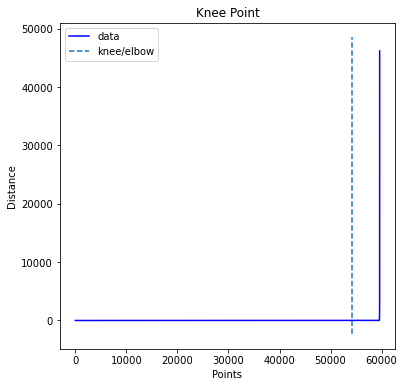

In [43]:
min_samples, epsilon = choose_DBSCAN_params(quantity_labels_file, l_type = "Q11424", l_prop = "P2047")

In [44]:
db, values = DBSCAN_label_subset(quantity_labels_file, l_type = "Q11424", l_prop = "P2047", eps = epsilon, min_samples = min_samples)
view_clustering(db.labels_, values, bin_size = 1000)

ValueError: eps must be positive.

In [77]:
intervals = infer_intervals_from_clusters(values, db.labels_)
display(intervals)

[(None, 41699675.5),
 (41699675.5, 42070375.0),
 (42070375.0, 43152169.5),
 (43152169.5, 44616481.0),
 (44616481.0, 45753553.0),
 (45753553.0, 47679648.0),
 (47679648.0, 49304297.5),
 (49304297.5, 62309824.5),
 (62309824.5, 64595629.5),
 (64595629.5, 67584245.5),
 (67584245.5, 77075314.5),
 (77075314.5, 78851500.0),
 (78851500.0, 81415700.0),
 (81415700.0, 83064200.0),
 (83064200.0, None)]